# Transport network density

## Introduction

This notebook is based on the [eu_grid_population.py](https://github.com/GISAdamToth/characteristics_of_transport_network_toolbox/blob/main/python_scripts/eu_grid_population.py) script, which is part of the [Calculation possibilies of transport network's characteristics of countries and cities](https://www.geoinformatics.upol.cz/dprace/bakalarske/toth22/) bachelor thesis by Adam Tóth (2022).

In this notebook you will calculate the transport network density in two ways:
1) "classic" approach, where density = length / area
2) "demographic" approach, where density = length / population

You'll need a cloned ArcGIS Python environment so you can run [**ArcPy**](https://pro.arcgis.com/en/pro-app/3.1/arcpy/get-started/what-is-arcpy-.htm) functions and install additional packages.

The workflow is divided into the following sections:
- [ArcGIS setup](#arcgis)
- [Transport network data](#osmnx)
- [Population data](#popgrid)
- [Hexagonal grid](#hex)
- [Density calculation](#calc)
- [Visualization](#vis)

## ArcGIS setup <a id="arcgis"></a>

Start ArcGIS Pro and create a new project.

Import **ArcPy** and allow overwriting outputs with the same name.

In [1]:
import arcpy
arcpy.env.overwriteOutput = True

Save the path to your project's geodatabase and set it as the workspace.

In [2]:
workspace = "D:/transport_netw_char/transport_netw_char.gdb/"
arcpy.env.workspace = workspace

## Transport network data <a id="osmnx"></a>

Transport network is a term which covers all parts of the transport infrastructure in a certain area, typically country, region or city. Transport network therefore includes roads, railways, airports, river and sea ports (harbours), pipelines, all kinds of junctions, terminals and so on. This notebook focuses on the line features of transport network, because the density is expressed as **length** either per area or per capita. 

Therefore you can use any kind of line layer representing highways, streets, railways for example. In this part you'll go through the process of accessing railways data from OpenStreetMap (OSM) and getting them ready for further work in ArcGIS Pro.

This part is inspired by the notebook [Accessing OSM Data in Python](https://pygis.io/docs/d_access_osm.html) published at PyGIS.

The first step is to choose the area of interest. You can choose any European city, region or country. For this notebook the area of interest will be Bratislava.

In [10]:
place_name = "Bratislava, Slovakia"

You'll need [**OSMnx**](https://osmnx.readthedocs.io/en/stable/) and [**GeoPandas**](https://geopandas.org/en/stable/) packages. There are various ways how to install them into your cloned ArcGIS Python environment, one simple way is to uncomment and execute the next two code lines.

In [ ]:
# %pip install osmnx
# %pip install geopandas

Import the packages now.

In [2]:
import osmnx as ox
import geopandas as gpd

c:\Users\dzuky\AppData\Local\ESRI\conda\envs\arcgispro-py3-proda-clone\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\dzuky\AppData\Local\ESRI\conda\envs\arcgispro-py3-proda-clone\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
c:\Users\dzuky\AppData\Local\ESRI\conda\envs\arcgispro-py3-proda-clone\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


Using the functionality of imported packages, save the area of interest as a GeoDataFrame into the variable ```area``` and check how is looks like.

In [8]:
area = ox.geocode_to_gdf(place_name)
area

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"MULTIPOLYGON (((16.96590 48.22633, 16.97064 48...",48.254545,48.017887,17.240053,16.965899,199697906,relation,3992676,48.15926,17.139659,place,city,15,0.672722,city,Bratislava,"Bratislava, Region of Bratislava, Slovakia"


You can also verify its data type and plot it using [**matplotlib**](https://matplotlib.org/) built-in the **GeoPandas** package.

<class 'geopandas.geodataframe.GeoDataFrame'>


<AxesSubplot:>

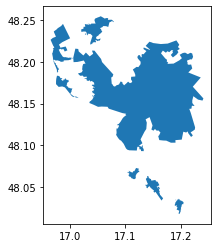

In [9]:
print(type(area))
area.plot()

## Population data <a id="popgrid"></a>

Variables ```data``` and ```area``` store the roads and area of interest layers names.

In [3]:
data = "osm_roads_clipped"
area = "main_FI003L4_TURKU_UA2018_Boundary"

In [4]:
pop_data = "D:/3.ZS/bakalarka/EU_POP_GRID_2018/JRC_POPULATION_2018.shp"
size = "10 SquareKilometers"

Select the population grid "pixels" that intersect with the area of interest. Copy or export these pixels into your workspace and then don't forget to clear the selection.

In [10]:
control_selection = arcpy.management.SelectLayerByLocation(pop_data, "INTERSECT", area)
arcpy.management.CopyFeatures(control_selection, "pop_data_copy")
control_selection = arcpy.management.SelectLayerByAttribute(pop_data, "CLEAR_SELECTION")


Save the "pixel" area size in a new field which will be named ```"area_orig"```. You will make a copy of the ```"Shape_Area"``` field basically.

In [11]:
arcpy.management.AddField("pop_data_copy", "area_orig", "DOUBLE")
arcpy.management.CalculateField("pop_data_copy", "area_orig", '!Shape_Area!')

<Result 'D:/transport_netw_char/transport_netw_char.gdb\\pop_data_copy'>

Clip the copied/exported population grid "pixels" by the area of interest.

In [12]:
arcpy.analysis.Clip("pop_data_copy", area, "clipped_pop_data")
pop_data = "clipped_pop_data"

Add a new field named ```"P_2018_orig"``` and populate it with the current population.

In [14]:
arcpy.management.AddField(pop_data, "P_2018_orig", "DOUBLE")
arcpy.management.CalculateField(pop_data, "P_2018_orig", '(!TOT_P_2018!/!area_orig!)*!Shape_Area!')

<Result 'D:/transport_netw_char/transport_netw_char.gdb\\clipped_pop_data'>

## Hexagonal grid <a id="hex"></a>

Generate a hexagonal grid of hexagon size 10 $km$ over the area of interest and then clip it by its polygon layer.

In [15]:
arcpy.management.GenerateTessellation("hex_grid", area, "HEXAGON", size)
arcpy.analysis.Clip("hex_grid", area, "hex_gr")

<Result 'D:/transport_netw_char/transport_netw_char.gdb\\hex_gr'>

Field ```"area_orig"``` will contain the area size of current clipped "pixels".

In [16]:
arcpy.management.CalculateField(pop_data, "area_orig", '!Shape_Area!')

<Result 'D:/transport_netw_char/transport_netw_char.gdb\\clipped_pop_data'>

Now you'll get the population information into the hexagons. Intersect first the population grid by the hexagonal grid.

In [17]:
arcpy.analysis.Intersect([pop_data, "hex_gr"], "pop_data_isect", "ALL")

<Result 'D:/transport_netw_char/transport_netw_char.gdb\\pop_data_isect'>

Add field into the intersected population grid's attribute table and calculate there population size using the same principle as it was used when calculating population after clipping.

In [18]:
arcpy.management.AddField("pop_data_isect", "new_pop2018", "DOUBLE")
arcpy.management.CalculateField("pop_data_isect", "new_pop2018", '(!P_2018_orig!/!area_orig!)*!Shape_Area!')

<Result 'D:/transport_netw_char/transport_netw_char.gdb\\pop_data_isect'>

Dissolve the population grid's "pixels" by hexagon's ID while summing the ```"new_pop2018"``` field and then join this field to the hexagonal grid layer.

In [9]:
arcpy.management.Dissolve("pop_data_isect", "pop_data_isect_diss", "FID_hex_gr", [["new_pop2018","SUM"]])
arcpy.management.JoinField("hex_gr", "OBJECTID", "pop_data_isect_diss", "FID_hex_gr", ["SUM_new_pop2018"])

<Result 'D:/transport_netw_char/transport_netw_char.gdb\\hex_gr'>

In [19]:
no_people = arcpy.management.SelectLayerByAttribute("hex_gr", "NEW_SELECTION", "SUM_new_pop2018 IS NULL")
arcpy.management.CalculateField(no_people, "SUM_new_pop2018", '0.0')
arcpy.management.SelectLayerByAttribute("hex_gr", "CLEAR_SELECTION")

<Result 'hex_gr_Layer17'>

Select major roads, links to those roads and minor roads from the OSM roads layer and export them into a new layer.

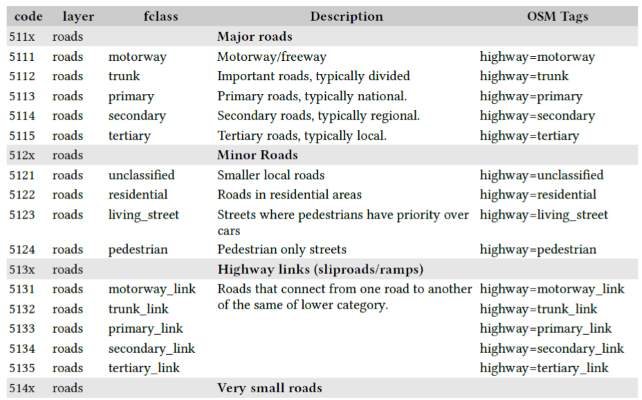

In [7]:
arcpy.conversion.ExportFeatures(data, "roads_filtered", "code > 5110 And code < 5136")
data = "roads_filtered"

Cut the roads with hexagonal grid and dissolve them by hexagon's ID.

In [8]:
arcpy.analysis.Intersect([data, "hex_gr"], "rd_isect", "ONLY_FID")
arcpy.management.Dissolve("rd_isect", "rd_isect_diss", "FID_hex_gr")

<Result 'D:/transport_netw_char/transport_netw_char.gdb\\rd_isect_diss'>

Save the roads length in each hexagon by creating new field named ```"rd_length"``` and populating it with the values from the ```"Shape_Length"``` field. Join this information to the hexagonal grid layer.

In [11]:
arcpy.management.AddField("rd_isect_diss", "rd_length", "DOUBLE")
arcpy.management.CalculateField("rd_isect_diss", "rd_length", '!Shape_Length!')
arcpy.management.JoinField("hex_gr", "OBJECTID", "rd_isect_diss", "FID_hex_gr", ["rd_length"])

<Result 'D:/transport_netw_char/transport_netw_char.gdb\\hex_gr'>

In [17]:
no_roads = arcpy.management.SelectLayerByAttribute("hex_gr", "NEW_SELECTION", "rd_length IS NULL")
arcpy.management.CalculateField(no_roads, "rd_length", '0.0')
arcpy.management.SelectLayerByAttribute("hex_gr", "CLEAR_SELECTION")

<Result 'hex_gr_Layer8'>

## Density Calculation <a id="calc"></a>

Now the hexagonal grid contains all the information you need to calculate both roads densities. Add new fields for these. Remember that the default units are $m$ and $m^2$ and the units of densities are *n* $km$ of roads per 1 $km^2$ of area and *n* $km$ of roads per 1 inhabitant.

In [5]:
arcpy.management.AddFields("hex_gr", [["rd_density", "DOUBLE"], ["rd_per_capita", "DOUBLE"]])

<Result 'D:/transport_netw_char/transport_netw_char.gdb\\hex_gr'>

In [6]:
arcpy.management.CalculateField("hex_gr", "rd_density", '(!rd_length!/1000)/(!Shape_Area!/1000000)')

<Result 'D:/transport_netw_char/transport_netw_char.gdb\\hex_gr'>

In [8]:
fields = ["rd_per_capita", "rd_length", "SUM_new_pop2018"]

with arcpy.da.UpdateCursor("hex_gr", fields) as cursor:
     for row in cursor:
        if (row[2] == 0.0):
            row[0] = 0.0
        else:
            row[0] = row[1] / row[2]

        cursor.updateRow(row)

## Visualization <a id="vis"></a>